<a href="https://colab.research.google.com/github/codebluecruz/Getting-started-with-github/blob/master/actual%20webmd%20lstm_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis w/ Python

This kernel comprise exploratory data analysis on the provided data, including: 
- Data loading
- Data cleaning 
- Descriptive Analysis
- Temporal Analysis
- Sentiment Analysis
- Text Analysis
- Importing Models
- Comparing Classifier outputs
- Hyperparameter Optimisation
- Evaluating Results(Accuracy, F1-Score, Roc_auc score, ROC_AUC Cruve)



In [223]:
# Importing all libraries which will be used for our model
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import re
import seaborn as sns
import string
import html
from sklearn.preprocessing import normalize, MinMaxScaler
from scipy.stats import spearmanr, pearsonr

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [224]:
# Environment used for codefile if GooGle Collaboratory, Here we're mounting our google drive as all our data is saved on drive itself,
# saves us from upload time.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Data

Since we are just doing an exploratory analysis of the data, **we are going to concatenate test and train data into one dataset**.

In [375]:
# Reading data 
drugs = pd.read_csv('/content/drive/My Drive/newset_webmd.csv', skiprows=0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,7,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [376]:
# droping any NaN rows from our dataset, changing all string values to LowerCase, removing Date column as it doesnt seem to be of much use.
drugs = drugs.dropna(how = 'any', axis = 0)
drugs.shape
drugs.columns = drugs.columns.str.lower()
drugs.reset_index(drop = True, inplace = True)
drugs['condition'].isnull().sum(axis = 0)
#dropping unnecessary columns
drugs.drop(['date', 'sex', 'sides'], axis=1, inplace=True)
drugs = drugs.drop_duplicates(subset=['reviews'], keep='first')

In [377]:
# example of random undersampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
# define dataset
#X, y = make_classification(n_samples=10000, weights=[0.99], flip_y=0)
# summarize class distribution
print(Counter(drugs['satisfaction']))
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='all')
# fit and apply the transform
X_over, y_over = undersample.fit_resample(drugs.drop(['satisfaction'], axis=1), drugs['satisfaction'])
# summarize class distribution
print(Counter(y_over))

Counter({1.0: 27616, 5.0: 27277, 4.0: 14026, 3.0: 11424, 2.0: 8494})
Counter({1.0: 8494, 2.0: 8494, 3.0: 8494, 4.0: 8494, 5.0: 8494})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [378]:
drugs=pd.DataFrame(X_over)
drugs1=pd.DataFrame(y_over)

In [379]:
drugs1.rename(columns={0:'satisfaction'}, inplace = True)
drugs1.head(1)

,satisfaction
0,1.0


In [380]:
drugs.rename(columns = {0:'age', 1:'condition',2:'drug',3:'drugid',4:'easeofuse',5:'effectiveness', 6:'reviews',7:'usefulcount'}, inplace = True)
drugs.head(1)

,age,condition,drug,drugid,easeofuse,effectiveness,reviews,usefulcount
0,55-64,"""Change of Life"" Signs",venlafaxine hcl,4870,4,1,does nothing for hot flashes,0


In [381]:
drugs = pd.concat([drugs, drugs1], axis = 1)
drugs.shape
drugs.head(1)

,age,condition,drug,drugid,easeofuse,effectiveness,reviews,usefulcount,satisfaction
0,55-64,"""Change of Life"" Signs",venlafaxine hcl,4870,4,1,does nothing for hot flashes,0,1.0


In [382]:
# shuffle data to prepare final dataset
drugs=drugs.sample(frac=1)

## Data Cleaning and Data Glimpse

We are willing to check if this dataset have some corrupted data or non present values. 

**condition** is a field which present problems in 1171 registers, probably due to some bug in the data web scraping. The value of those registers is the usefulCount value with an ```span``` HTML tag and the following text: ```users found this comment helpful```. We ignored these registers.

In [383]:
# Let's delete all of these corrupted rows
print("Number of Corrupted Reviews: ", len(drugs[drugs.condition.str.contains(" users found this comment helpful.",na=False)]))
drugs = drugs[~drugs.condition.str.contains(" users found this comment helpful.",na=False)]

Number of Corrupted Reviews:  0


In [384]:
drugs.describe()

,satisfaction
count,42470.00000
mean,3.00000
std,1.41423
min,1.00000
25%,2.00000
50%,3.00000
75%,4.00000
max,5.00000


In [385]:
### Thought flow for Depression Confidence Intervals
"""
I want to take the df, filter by condition, drug, confidence interval, sample size cutoff)
Then loop through all the drugs for a specific condition and calculate their
mean, top limit, and bottom limit. 
"""
# Create Confidence Interval Function
def confidence_interval (data, ci_percent):
  data = np.array(data) # Makes sure our data is in a numpy array
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + ci_percent) / 2., n - 1)
  return (mean, mean - interval, mean + interval)


def condition_compare (drugs, condition_id, ci_percent, sample_size_cutoff):
  output_names = ["Drug Name", "Sample Mean", "Lower Bound", "Upper Bound", "Sample Size"]
  drug_compare = []
  data = drugs[drugs.condition == condition_id]
  for drug in data.drug.unique():
    one_drug = data[data.drug == drug].satisfaction
    if one_drug.size > sample_size_cutoff:
      mean, ilower, iupper= confidence_interval(one_drug, ci_percent)
      entry = [drug, mean, ilower, iupper, one_drug.size]
      drug_compare.append(entry)
  return pd.DataFrame(drug_compare, columns=output_names)


drugs2 = condition_compare(drugs, "Cough", 0.95, 10).sort_values(by="Sample Mean", ascending=False)
drugs2

,Drug Name,Sample Mean,Lower Bound,Upper Bound,Sample Size
2,tussionex,4.000000,3.561457,4.438543,30
4,tussicaps,3.636364,2.541800,4.730927,11
0,tessalon perle,3.252033,2.956171,3.547894,123
3,promethazine-codeine,3.214286,2.392154,4.036417,14
1,promethazine-dm,2.809524,2.053037,3.566011,21
5,virtussin ac,2.736842,1.859181,3.614503,19


In [386]:
#We have created a column named "uniqueid" for every row, to easen up or operations.
drugs['uniqueid'] = np.arange(len(drugs))
drugs.head()

,age,condition,drug,drugid,easeofuse,effectiveness,reviews,usefulcount,satisfaction,uniqueid
9045,45-54,A Progressive Disease of the Thyroid Gland,synthroid,7033,3,2,Is not helping me to get my TSH where it needs...,3,2.0,0
14780,25-34,Inactive Tuberculosis,rifampin,1744,2,4,I was exposed to TB at some point in my career...,5,2.0,1
25898,55-64,Migraine Prevention,propranolol hcl er,10404,5,5,"Male, 64. Migraines for many years. Been on th...",12,4.0,2
30072,55-64,Obstructive Pulmonary Disease,prednisone concentrate,6007,5,3,I've been taking Prednisone off and on my whol...,7,4.0,3
9990,65-74,Depression,wellbutrin xl,76851,4,3,confusion talking too much depression may be d...,5,2.0,4


In [387]:
# We will use this groupings later on...

print("Number of Reviews per Drug")
# Number of reviews per drug
reviews_per_drug = drugs.groupby(["drug"]).agg({
    "uniqueid": pd.Series.nunique
})
reviews_per_drug.describe()


print("Number of Reviews per Condition")
# Number of reviews per condition
reviews_per_condition = drugs.groupby(["condition"]).agg({
    "uniqueid": pd.Series.nunique
})

reviews_per_condition.describe()

Number of Reviews per Drug
Number of Reviews per Condition


,uniqueid
count,940.000000
mean,45.180851
std,257.504790
min,1.000000
25%,2.000000
50%,5.000000
75%,18.000000
max,6043.000000


In [388]:
# Inspect the lower cased reviews text. 
drugs['reviews'] = drugs['reviews'].str.lower()
drugs.head(5)

,age,condition,drug,drugid,easeofuse,effectiveness,reviews,usefulcount,satisfaction,uniqueid
9045,45-54,A Progressive Disease of the Thyroid Gland,synthroid,7033,3,2,is not helping me to get my tsh where it needs...,3,2.0,0
14780,25-34,Inactive Tuberculosis,rifampin,1744,2,4,i was exposed to tb at some point in my career...,5,2.0,1
25898,55-64,Migraine Prevention,propranolol hcl er,10404,5,5,"male, 64. migraines for many years. been on th...",12,4.0,2
30072,55-64,Obstructive Pulmonary Disease,prednisone concentrate,6007,5,3,i've been taking prednisone off and on my whol...,7,4.0,3
9990,65-74,Depression,wellbutrin xl,76851,4,3,confusion talking too much depression may be d...,5,2.0,4


## Descriptive Analysis


### Top 10 Reviewed Drugs

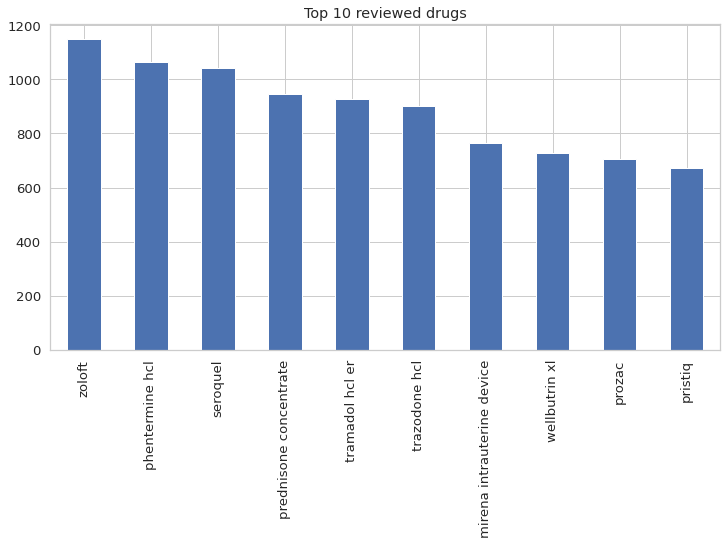

In [389]:
# Top 10 most reviewed drug names
plot = drugs.drug.value_counts().nlargest(10).plot(kind='bar', title="Top 10 reviewed drugs", figsize=(12,6))

### Top 10 conditions undergoing by drug reviewers

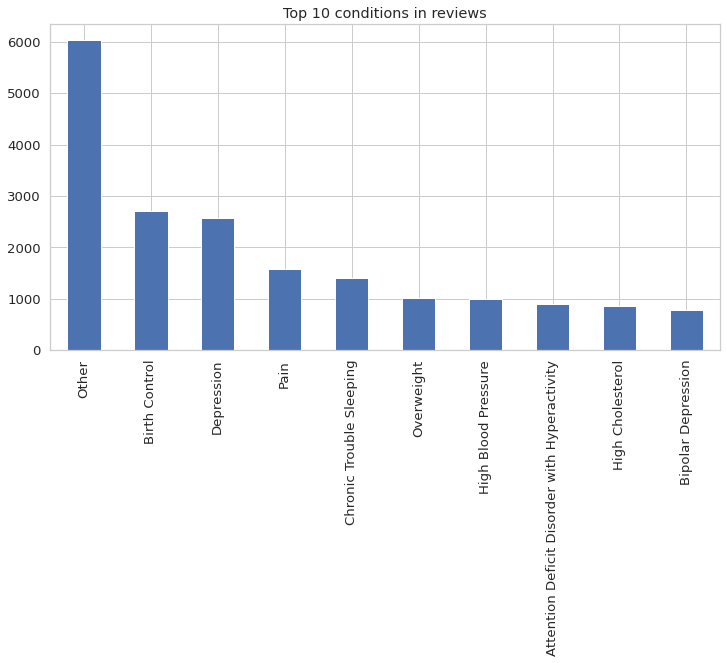

In [390]:
# Top 10 most suffered condition by reviewers
plot = drugs.condition.value_counts().nlargest(10).plot(kind='bar', title="Top 10 conditions in reviews", figsize=(12,6))

### Top 10 drugs with best and worst rating

When doing this analysis for all the drugs, there is a factor which affect the results: **the number of reviews of a drug**. I.e. if we want to compute the drug with best rating, the drug which in **only 1 review** was given a 10 rating would be in TOP 1. For this reason, we only consider drugs with a significant number of reviews. A significant number of reviews is when the number of reviews for a drug is above the 75% of the number of reviews distribution per drug.


Significant number of reviews: More than 15.0 reviews


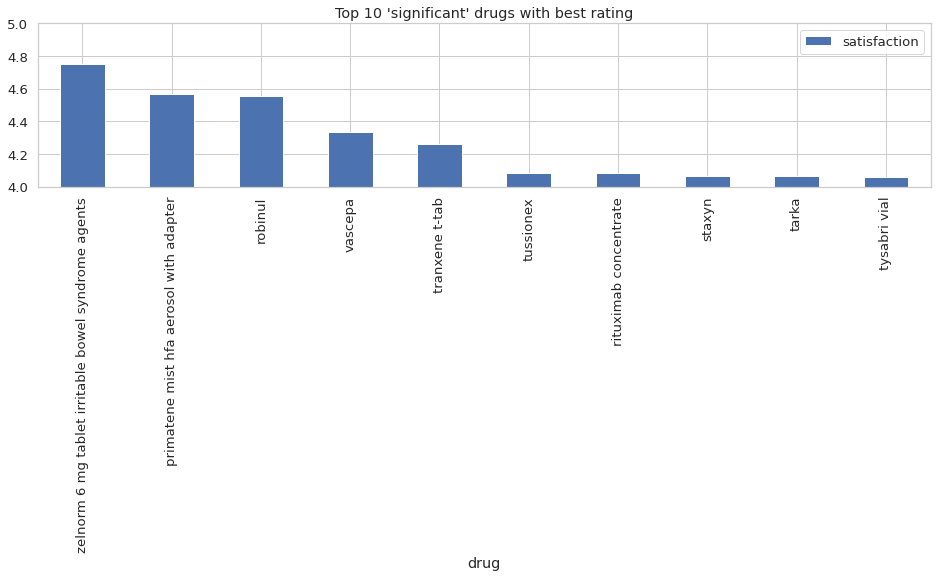

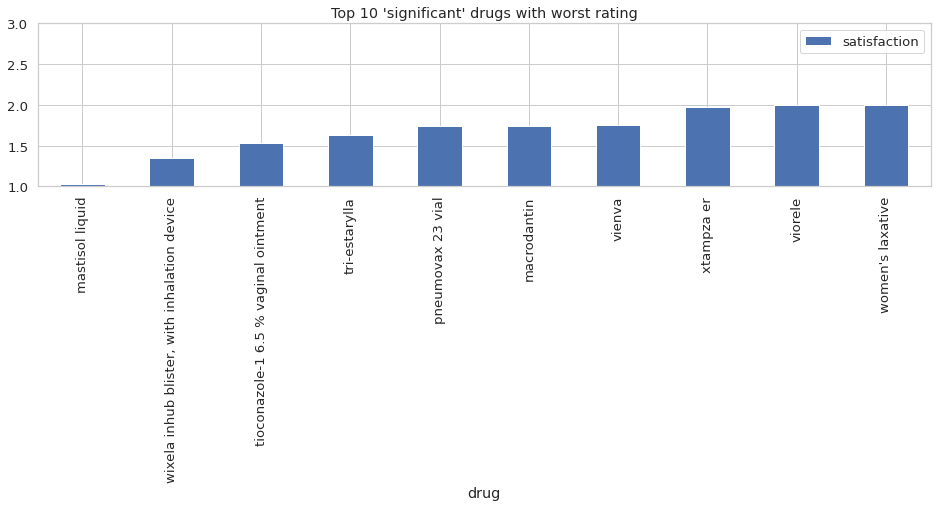

In [391]:
drugs_rating = drugs.groupby('drug').agg({
    'satisfaction': np.mean,
    'uniqueid': pd.Series.nunique
})

print("Significant number of reviews: More than", reviews_per_drug.quantile(q=0.75).values[0], "reviews")

# We only use the drugs which number of reviews is higher than a threshold
drugs_rating = drugs_rating[drugs_rating['uniqueid'] > int(reviews_per_drug.quantile(q=0.75))]

# Top 10
top_drugs_rating = drugs_rating.nlargest(10, 'satisfaction')
plot = top_drugs_rating.plot(y='satisfaction', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 'significant' drugs with best rating") # Assigned to variable to prevent output
dummy = plt.ylim(4, 5) # Assigned to variable to prevent output

# Bottom 10
bottom_drugs_rating = drugs_rating.nsmallest(10, 'satisfaction')
plot = bottom_drugs_rating.plot(y='satisfaction', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 'significant' drugs with worst rating") # Assigned to variable to prevent output
dummy = plt.ylim(1, 3) # Assigned to variable to prevent output

### Analyzing Pairs (Drug, Condition) with best and worst ratings

We theorize that the rating of a drug, is strongly related to the condition that the person who reviewed was suffering. We are going to compute the top 10 best and worst rating of reviews for (Drug, condition) pairs.

Number of pairs (Drug, Condition): 4176
Significant number of reviews: More than 7.0 reviews


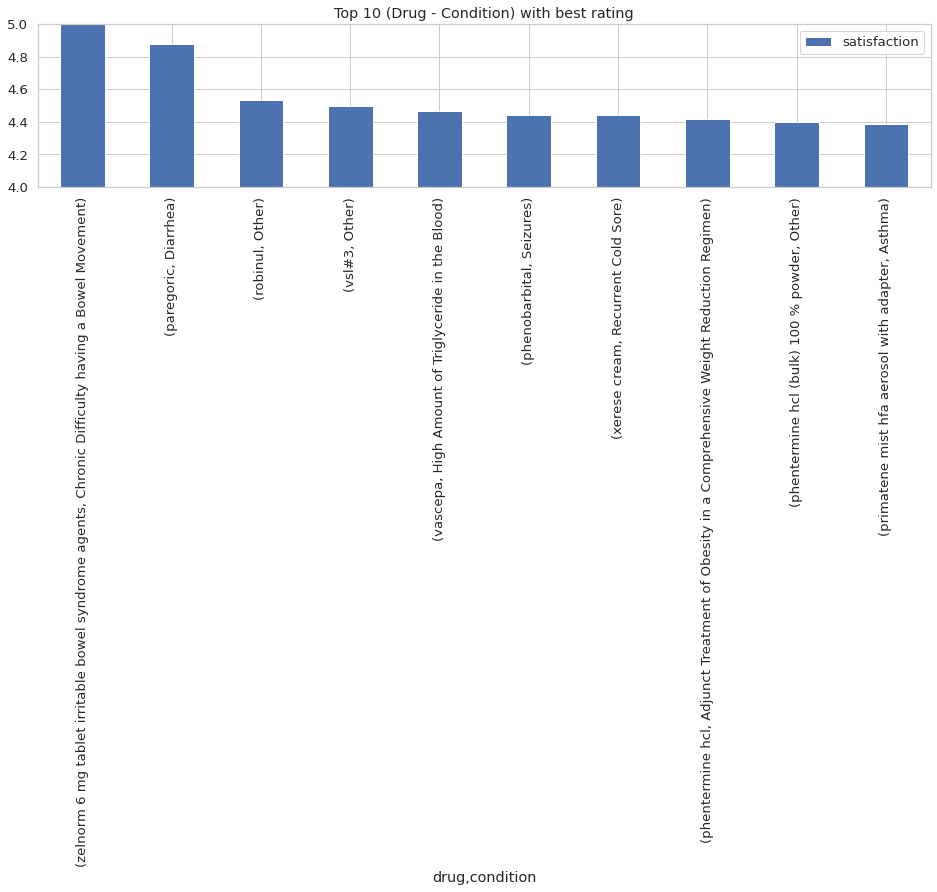

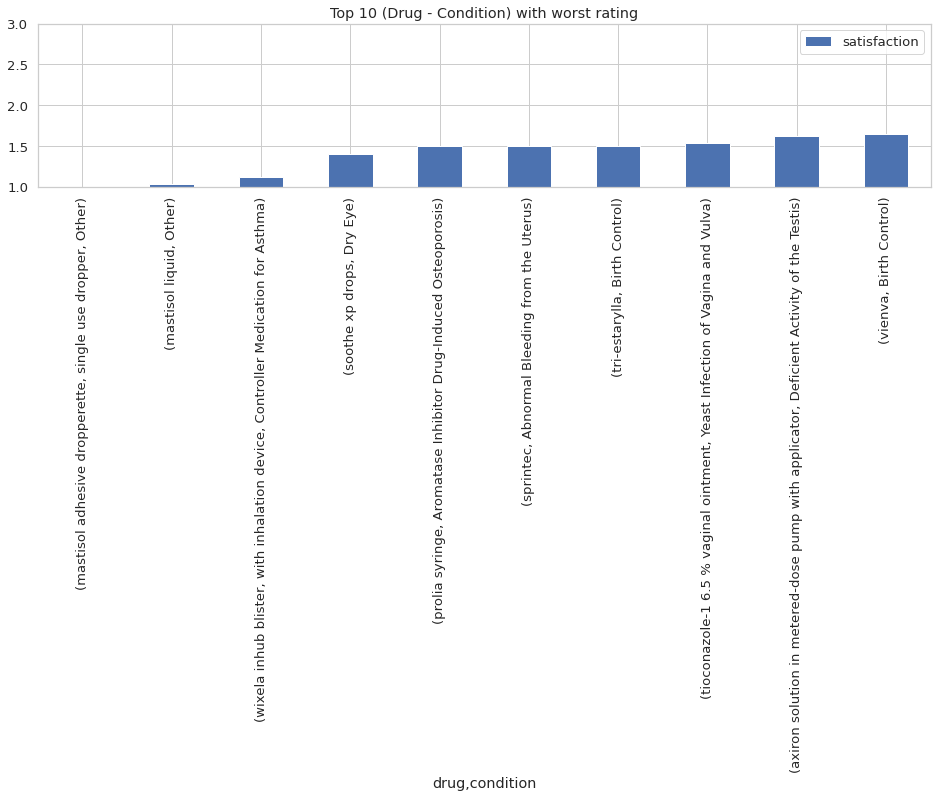

In [392]:
drugs_condition_rating = drugs.groupby(['drug', 'condition']).agg({
    'satisfaction': np.mean,
    'uniqueid': pd.Series.nunique
})

print("Number of pairs (Drug, Condition):", len(drugs_condition_rating))

print("Significant number of reviews: More than", drugs_condition_rating['uniqueid'].quantile(q=0.75), "reviews")

drugs_condition_rating = drugs_condition_rating[drugs_condition_rating['uniqueid'] > int(drugs_condition_rating['uniqueid'].quantile(q=0.75))]
# drugs_condition_rating.sort_values('rating', ascending=False)
top_drugs_condition_rating = drugs_condition_rating.nlargest(10, 'satisfaction')
plot = top_drugs_condition_rating.plot(y='satisfaction', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 (Drug - Condition) with best rating") # Assigned to variable to prevent output
dummy = plt.ylim(4, 5) # Assigned to variable to prevent output

bottom_drugs_condition_rating = drugs_condition_rating.nsmallest(10, 'satisfaction')
plot = bottom_drugs_condition_rating.plot(y='satisfaction', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 (Drug - Condition) with worst rating") # Assigned to variable to prevent output
dummy = plt.ylim(1, 3) # Assigned to variable to prevent output

## Temporal Analysis

Building a good prediction model is **no** trivial task. Temporal features ***could*** help a model to perform better if we can foresee some **temporal patterns**. We will analyze monthly patterns over different years of all the reviews.

In [393]:
# Our target column has been labeled as 1=Positive, 0= Negative, to get 1/0 output after we perform our operations on Reviews column.
# We only want a review to be classified either as Positive(1)(if rating is above 3) or Negative(0)(if rating is 3 and less).
labels = drugs['satisfaction'].map(lambda x : 1 if int(x) > 3 else 0)

In [394]:
# Function to perform cleansing operations on our Text column
def clean_reviews(reviews):
    
    ## Remove puncuation
    reviews = reviews.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    reviews = reviews.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    reviews = [w for w in reviews if not w in stops and len(w) >= 3]
    
    reviews = " ".join(reviews)

    # Clean the reviews
    reviews = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", reviews)
    reviews = re.sub(r"what's", "what is ", reviews)
    reviews = re.sub(r"\'s", " ", reviews)
    reviews = re.sub(r"\'ve", " have ", reviews)
    reviews = re.sub(r"n't", " not ", reviews)
    reviews = re.sub(r"i'm", "i am ", reviews)
    reviews = re.sub(r"\'re", " are ", reviews)
    reviews = re.sub(r"\'d", " would ", reviews)
    reviews = re.sub(r"\'ll", " will ", reviews)
    reviews = re.sub(r",", " ", reviews)
    reviews = re.sub(r"\.", " ", reviews)
    reviews = re.sub(r"!", " ! ", reviews)
    reviews = re.sub(r"\/", " ", reviews)
    reviews = re.sub(r"\^", " ^ ", reviews)
    reviews = re.sub(r"\+", " + ", reviews)
    reviews = re.sub(r"\-", " - ", reviews)
    reviews = re.sub(r"\=", " = ", reviews)
    reviews = re.sub(r"'", " ", reviews)
    reviews = re.sub(r"(\d+)(k)", r"\g<1>000", reviews)
    reviews = re.sub(r":", " : ", reviews)
    reviews = re.sub(r" e g ", " eg ", reviews)
    reviews = re.sub(r" b g ", " bg ", reviews)
    reviews = re.sub(r" u s ", " american ", reviews)
    reviews = re.sub(r"\0s", "0", reviews)
    reviews = re.sub(r" 9 11 ", "911", reviews)
    reviews = re.sub(r"e - mail", "email", reviews)
    reviews = re.sub(r"j k", "jk", reviews)
    reviews = re.sub(r"\s{2,}", " ", reviews)
    
    reviews = reviews.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in reviews]
    reviews = " ".join(stemmed_words)

    return reviews

In [395]:
drugs['reviews_clean'] = drugs['reviews'].map(lambda x: clean_reviews(x))

In [396]:
drugs.shape

(42470, 11)

In [397]:
drugs_copy=drugs

## Sentiment Analysis

We will analyze the sentiment of the reviews. We theorize that **the sentiment embedded on a review can be a key factor** to determine the review rating, the review impact on people (usefulCount), or how good a drug is for an specific condition. 

However, reviews can expose many different manifestations, such as: condition symptoms (usually negative), feelings before the drug (usually negative), feelings after the drug (could be positive or negative), side effects (usually negative), symptoms after the drug (could be positive or negative). This mix of manifestations could make any sentiment analysis method to struggle determining a single score for the entire review. Therefore, a aspect-based S.A. could be more viable (such as the ones used by Gräßer et al.).

For now, we are going to use Vader [1], a rule-based sentiment analysis approach available in Python NLTK. To **obtain a single sentiment score for every review** (-1|negative to 1|positive), and see how it correlates with ratings (spearman coeff.).

Before doing this, **text** must be processed:

- HTML characters are converted to legible text
- Punctuation signs are removed

[1] Gilbert, C. H. E. (2014). Vader: A parsimonious rule-based model for sentiment analysis of social media text. In Eighth International Conference on Weblogs and Social Media (ICWSM-14). Available at (20/04/16) http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf.

#### CNN LSTM o/p
- We're now trying to improve our operations on Reviews column using CNN+LSTM, the reason being, LSTM takes into consideration the sequences of our model in its Cell State, which is really important for any Text Data, coz it gives meaning to it.
- "I Love Dogs" in this sequence is meaningful but "Dog Love I" sounds confusing. than again with longer text size, the sequences or order becomes more important.
- We'll be using embedding layer for Word Embeddings, which helps us to see semantics or meaning behind "Reviews", being positive or negative.
- Tokeniser helps in encoding our data
- We have padded our Reviews accordingly, considering the maximum length of a Review.

In [398]:
train_sentences = drugs['reviews'].map(lambda x: clean_reviews(x))

In [399]:
drugs['reviews']

9045     is not helping me to get my tsh where it needs...
14780    i was exposed to tb at some point in my career...
25898    male, 64. migraines for many years. been on th...
30072    i've been taking prednisone off and on my whol...
9990     confusion talking too much depression may be d...
                               ...                        
13876    i took this for three years and gained 25 lbs....
40575    i think this med is a great pain reliever i ha...
28368    makes me a little slow to respond or light fee...
7691     i was switched from my previous birth control,...
32791    i am on prometrium 200 mgs., take for ten days...
Name: reviews, Length: 42470, dtype: object

In [400]:
train_sentences

9045                          help get tsh need be + + + +
14780    expos point career i am sure when found ltbi l...
25898    male 64 migrain mani year medicin month zero h...
30072    i have take prednison whole life born asthma n...
9990                  confus talk much depress may decreas
                               ...                        
13876    took three year gain lbs work often feel like ...
40575    think med great pain reliev tmj sever migrain ...
28368    make littl slow respond light feel howev benef...
7691     switch previous birth control loestrin fe drug...
32791    prometrium 200 mgs take ten day begin two week...
Name: reviews, Length: 42470, dtype: object

In [401]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from tqdm import tqdm
nltk.download('punkt') ## added for GoogleCollab
nltk.download('wordnet') ## added for GoogleCollab


def clean_sentences(reviews):
    reviews = []

    for sent in tqdm(train_sentences):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [402]:
train_sentences = clean_sentences(train_sentences)

100%|██████████| 42470/42470 [00:26<00:00, 1605.21it/s]


In [403]:
unique_words = set()
len_max = 0

for sent in tqdm(train_sentences):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

100%|██████████| 42470/42470 [00:00<00:00, 380031.34it/s]

26698
236


In [404]:
# oov_tok replaces unknown words with "<OOV>" as a value
# incase truncating is requirred out model will do so behind the text rows.
trunc_type='post'
oov_tok="<OOV>"
tokenizer = Tokenizer(num_words= len(list(unique_words)), oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

sequences = tokenizer.texts_to_sequences(train_sentences)
data = pad_sequences(sequences, maxlen=len_max, truncating=trunc_type)

In [405]:
# Early stopping incase scores doesnt change aroung cycles.
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_auc', patience = 2)
callback = [early_stopping]

In [406]:
from keras.utils import to_categorical
#target=train.Satisfaction.values
y_target=to_categorical(drugs['satisfaction'])
num_classes=y_target.shape[1]

In [407]:
num_classes

6

In [408]:
# we have used one LSTM layer for our operations, with a combination of a CNN Layer coz it really speeds up our task,
# further Maxpooling helps in reducing the problem of high dimensionality coz LSTM would usually return 2D array.
# Sigmoid activator is used coz we have binary(0/1) semantics for our reviews
# Two layer LSTM can also be implmented(with return sequence "True" meaning the feedback cycle will be used) but 
# for now i have commented them out.
import tensorflow as tf
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(len(list(unique_words)), 300, input_length=len_max))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(256, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(128))
    
    model_conv.add(Dense(num_classes, activation='softmax'))
    model_conv.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=[tf.keras.metrics.AUC()])
    model_conv.summary()
    return model_conv

In [409]:
model_conv = create_conv_model()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 236, 300)          8009400   
_________________________________________________________________
dropout_9 (Dropout)          (None, 236, 300)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 232, 256)          384256    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 58, 256)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 774       
Total params: 8,591,550
Trainable params: 8,591,550
Non-trainable params: 0
____________________________________________

In [410]:
history =model_conv.fit(data, y_target, validation_split=0.4, epochs = 2, callbacks=callback)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25482 samples, validate on 16988 samples
Epoch 1/2
25482/25482 [==============================] - 150s 6ms/step - loss: 1.4503 - auc_8: 0.7018 - val_loss: 1.3836 - val_auc_8: 0.7599
Epoch 2/2
   32/25482 [..............................] - ETA: 2:13 - loss: 1.2498 - auc_8: 0.7654

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: val_loss,val_auc_8,loss,auc_8
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


25482/25482 [==============================] - 153s 6ms/step - loss: 1.2369 - auc_8: 0.7826 - val_loss: 1.3986 - val_auc_8: 0.7930


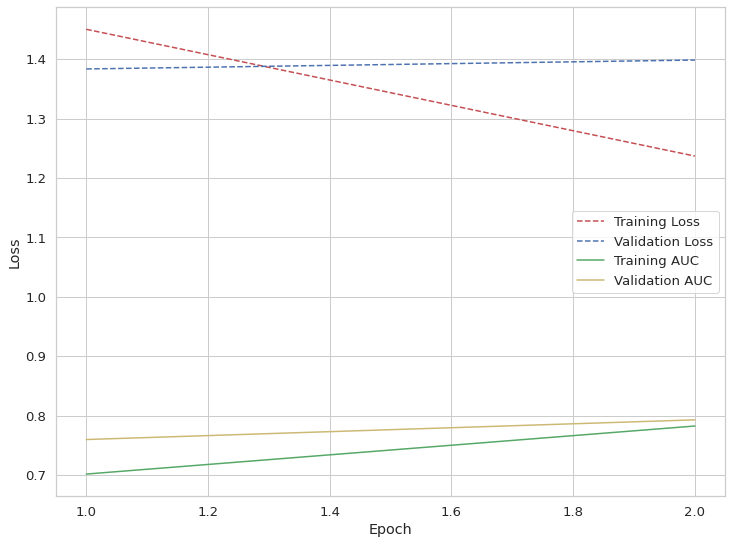

In [411]:
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b--')
plt.plot(epoch_count, history.history['auc_8'], 'g-')
plt.plot(epoch_count, history.history['val_auc_8'], 'y-')
plt.legend(['Training Loss', 'Validation Loss', 'Training AUC', 'Validation AUC'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [412]:
#df_save = pd.DataFrame(data)
#df_label = pd.DataFrame(np.array(labels))
#np.array(labels)

In [413]:
#df_label_copy=df_label

In [414]:
nlp_pred=model_conv.predict_classes(data)

In [415]:
lstm_op=pd.DataFrame(nlp_pred)
#df_labels=pd.DataFrame(labels)
df_target=pd.DataFrame(y_target)

In [416]:
lstm_op

,0
0,3
1,4
2,5
3,5
4,2
...,...
42465,1
42466,5
42467,4
42468,1


In [418]:
df_target

,0,1,2,3,4,5
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
42465,0.0,0.0,1.0,0.0,0.0,0.0
42466,0.0,0.0,0.0,0.0,0.0,1.0
42467,0.0,0.0,0.0,0.0,1.0,0.0
42468,0.0,1.0,0.0,0.0,0.0,0.0


In [419]:
lstm_op.rename(columns = {0:'lstm_score'}, inplace = True)
lstm_op

,lstm_score
0,3
1,4
2,5
3,5
4,2
...,...
42465,1
42466,5
42467,4
42468,1


In [420]:
# the last column being our output column
#drugs = pd.concat([drugs, lstm_op], axis = 1)
drugs = pd.concat([drugs_copy.reset_index(), lstm_op.reset_index()], axis = 1)


In [421]:
drugs.head()

,index,age,condition,drug,drugid,easeofuse,effectiveness,reviews,usefulcount,satisfaction,uniqueid,reviews_clean,index,lstm_score
0,9045,45-54,A Progressive Disease of the Thyroid Gland,synthroid,7033,3,2,is not helping me to get my tsh where it needs...,3,2.0,0,help get tsh need be + + + +,0,3
1,14780,25-34,Inactive Tuberculosis,rifampin,1744,2,4,i was exposed to tb at some point in my career...,5,2.0,1,expos point career i am sure when found ltbi l...,1,4
2,25898,55-64,Migraine Prevention,propranolol hcl er,10404,5,5,"male, 64. migraines for many years. been on th...",12,4.0,2,male 64 migrain mani year medicin month zero h...,2,5
3,30072,55-64,Obstructive Pulmonary Disease,prednisone concentrate,6007,5,3,i've been taking prednisone off and on my whol...,7,4.0,3,i have take prednison whole life born asthma n...,3,5
4,9990,65-74,Depression,wellbutrin xl,76851,4,3,confusion talking too much depression may be d...,5,2.0,4,confus talk much depress may decreas,4,2


In [422]:
#lstm_output=result.iloc[:,-1]
#lstm_output.shape

In [423]:
#lstm_output

In [424]:
#df_n = lstm_output.apply(lambda x: x.idxmax(), axis = 1)

In [425]:
#df_n

In [426]:
# We can see how much we have improved on correlation btw our semantics and target columns.
#np.corrcoef(lstm_op, drugs['satisfaction'])

In [427]:
#drugs = pd.concat([drugs.reset_index(), lstm_output.reset_index()], axis = 1)

In [428]:
#drugs.shape

In [429]:
# We are renaming our LSTM score from "0" to "lstm_score"
#drugs.rename(columns = {0:'lstm_score'}, inplace = True)
#drugs.head(1)

In [430]:
drugs.drop(['index'], axis=1, inplace=True)
drugs.head(1)

,age,condition,drug,drugid,easeofuse,effectiveness,reviews,usefulcount,satisfaction,uniqueid,reviews_clean,lstm_score
0,45-54,A Progressive Disease of the Thyroid Gland,synthroid,7033,3,2,is not helping me to get my tsh where it needs...,3,2.0,0,help get tsh need be + + + +,3


In [431]:
# Counting how many times each condition occured in our dataset, with head of 20
drugs['condition'].value_counts().head(20)

Other                                                        6043
Birth Control                                                2712
Depression                                                   2580
Pain                                                         1585
Chronic Trouble Sleeping                                     1407
Overweight                                                   1026
High Blood Pressure                                          1000
Attention Deficit Disorder with Hyperactivity                 898
High Cholesterol                                              868
Bipolar Depression                                            782
Migraine Prevention                                           776
Major Depressive Disorder                                     668
Disorder characterized by Stiff, Tender & Painful Muscles     579
Panic Disorder                                                548
Migraine Headache                                             523
Rheumatoid

# Feature Engineering

In [432]:
#Word count in each review
drugs['count_word']=drugs["reviews_clean"].apply(lambda x: len(str(x).split()))

#Unique word count 
drugs['count_unique_word']=drugs["reviews_clean"].apply(lambda x: len(set(str(x).split())))

#Letter count
drugs['count_letters']=drugs["reviews_clean"].apply(lambda x: len(str(x)))

#punctuation count
drugs["count_punctuations"] = drugs["reviews"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))


#Number of stopwords
stops = set(stopwords.words("english"))
drugs["count_stopwords"] = drugs["reviews"].apply(lambda x: len([w for w in str(x).lower().split() if w in stops]))

#Average length of the words
drugs["mean_word_len"] = drugs["reviews_clean"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [433]:
# Label Encoding Conditions
from sklearn.preprocessing import LabelEncoder
label_encoder_feat = {}
for feature in ['condition']:
    label_encoder_feat[feature] = LabelEncoder()
    drugs[feature] = label_encoder_feat[feature].fit_transform(drugs[feature])

In [434]:
drugs['easeofuse']=drugs['easeofuse'].astype(float)
drugs['effectiveness']=drugs['effectiveness'].astype(float)
drugs['usefulcount']=drugs['usefulcount'].astype(float)

In [435]:
corr=drugs.corr(method ='pearson')

In [436]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,condition,easeofuse,effectiveness,usefulcount,satisfaction,uniqueid,lstm_score,count_word,count_unique_word,count_letters,count_punctuations,count_stopwords,mean_word_len
condition,1.00,-0.02,-0.03,-0.01,0.04,0.00,0.02,-0.05,-0.05,-0.04,-0.04,-0.05,0.01
easeofuse,-0.02,1.00,0.47,0.04,0.49,-0.00,0.35,0.00,0.01,0.00,0.01,0.02,-0.02
effectiveness,-0.03,0.47,1.00,0.06,0.73,-0.00,0.49,0.07,0.08,0.07,0.06,0.08,-0.01
usefulcount,-0.01,0.04,0.06,1.00,0.07,-0.00,0.05,0.19,0.20,0.20,0.18,0.18,-0.01
satisfaction,0.04,0.49,0.73,0.07,1.00,-0.00,0.67,-0.02,-0.03,-0.03,-0.03,-0.01,-0.01
uniqueid,0.00,-0.00,-0.00,-0.00,-0.00,1.00,0.01,0.00,0.00,0.00,0.00,0.00,-0.01
lstm_score,0.02,0.35,0.49,0.05,0.67,0.01,1.00,-0.02,-0.03,-0.03,-0.02,-0.01,-0.02
count_word,-0.05,0.00,0.07,0.19,-0.02,0.00,-0.02,1.00,0.99,1.00,0.91,0.94,-0.09
count_unique_word,-0.05,0.01,0.08,0.20,-0.03,0.00,-0.03,0.99,1.00,0.99,0.90,0.94,-0.08
count_letters,-0.04,0.00,0.07,0.20,-0.03,0.00,-0.03,1.00,0.99,1.00,0.90,0.95,-0.04


In [437]:
# Correlation Heatmap of the features engineered
#plt.rcParams['figure.figsize'] = [17,15]
#sns.set(font_scale = 1.2)
#corr = drugs.select_dtypes(include='float64').corr()
#sns_ = sns.heatmap(corr, annot = True, cmap = 'YlGnBu')
#plt.setp(sns_.get_xticklabels(), rotation = 45);

In [438]:
drugs = drugs.dropna(how = 'any', axis = 0)

In [439]:
drugs.isna().sum()

age                   0
condition             0
drug                  0
drugid                0
easeofuse             0
effectiveness         0
reviews               0
usefulcount           0
satisfaction          0
uniqueid              0
reviews_clean         0
lstm_score            0
count_word            0
count_unique_word     0
count_letters         0
count_punctuations    0
count_stopwords       0
mean_word_len         0
dtype: int64

In [440]:
drugs.dtypes

age                    object
condition               int64
drug                   object
drugid                 object
easeofuse             float64
effectiveness         float64
reviews                object
usefulcount           float64
satisfaction          float64
uniqueid                int64
reviews_clean          object
lstm_score              int64
count_word              int64
count_unique_word       int64
count_letters           int64
count_punctuations      int64
count_stopwords         int64
mean_word_len         float64
dtype: object

In [441]:
drugs.head(1)

,age,condition,drug,drugid,easeofuse,effectiveness,reviews,usefulcount,satisfaction,uniqueid,reviews_clean,lstm_score,count_word,count_unique_word,count_letters,count_punctuations,count_stopwords,mean_word_len
0,45-54,5,synthroid,7033,3.0,2.0,is not helping me to get my tsh where it needs...,3.0,2.0,0,help get tsh need be + + + +,3,9,6,28,1,8,2.222222


# Importing Libraries for the Machine Learning Model


In [442]:
# Importing Libraries for the Machine Learning Model
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMModel,LGBMClassifier, plot_importance
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import time
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score
from sklearn.model_selection import train_test_split, cross_val_predict


from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

In [443]:
drugs['satisfaction'].value_counts()

1.0    8493
5.0    8492
2.0    8491
4.0    8490
3.0    8487
Name: satisfaction, dtype: int64

In [444]:
# Defining Features and splitting the data as train and test set
features = drugs[[ 'effectiveness', 'lstm_score', 'easeofuse', 'condition', 'count_letters',
                   ]]

target = drugs['satisfaction']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, shuffle=True, random_state = 42)
print ("The Train set size ", X_train.shape)
print ("The Test set size ", X_test.shape)

The Train set size  (29717, 5)
The Test set size  (12736, 5)


#### Firstly we'll try and check which classifier performs the best with our training data, then we'll take that classifier and perform HyperParameter Optimisation on that model.

In [445]:
knn = KNeighborsClassifier()
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
precision_score_knn=precision_score(y_test, preds, average='micro')

lb = LabelBinarizer()
lb.fit(y_test)
y_test1 = lb.transform(y_test)
y_pred1= lb.transform(preds)
roc_auc_score_knn=roc_auc_score(y_test1, y_pred1, average="macro")
print("Roc_auc_score for test data: %3.5f " % (roc_auc_score_knn))
print("Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))
print("Precision on test dataset:", precision_score_knn)

Roc_auc_score for test data: 0.59089 
Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: 34.58
Time consumed for training: 0.032 seconds
Time consumed for prediction: 0.38874 seconds
Precision on test dataset: 0.3457914572864322


In [446]:
from sklearn.ensemble import GradientBoostingClassifier
gbk = GradientBoostingClassifier()
gbk.fit(X_train, y_train)

training_start = time.perf_counter()
gbk.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gbk.predict(X_test)
prediction_end = time.perf_counter()
acc_gbk = (preds == y_test).sum().astype(float) / len(preds)*100
gbk_train_time = training_end-training_start
gbk_prediction_time = prediction_end-prediction_start
precision_score_gbk=precision_score(y_test, preds, average='micro')

y_pred1= lb.transform(preds)
roc_auc_score_gbk=roc_auc_score(y_test1, y_pred1, average="macro")
print("Roc_auc_score for test data: %3.5f " % (roc_auc_score_gbk))
print("Scikit-Learn's GBK Classifier's prediction accuracy is: %3.2f" % (acc_gbk))
print("Time consumed for training: %4.3f seconds" % (gbk_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gbk_prediction_time))
print("Precision on test dataset:", precision_score_gbk)

Roc_auc_score for test data: 0.77039 
Scikit-Learn's GBK Classifier's prediction accuracy is: 63.25
Time consumed for training: 14.896 seconds
Time consumed for prediction: 0.12167 seconds
Precision on test dataset: 0.632537688442211


In [447]:
GNB= GaussianNB()
training_start = time.perf_counter()
GNB.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = GNB.predict(X_test)
prediction_end = time.perf_counter()
acc_gnb = (preds == y_test).sum().astype(float) / len(preds)*100
gnb_train_time = training_end-training_start
gnb_prediction_time = prediction_end-prediction_start
precision_score_gnb=precision_score(y_test, preds, average='micro')
y_pred1= lb.transform(preds)
roc_auc_score_gnb=roc_auc_score(y_test1, y_pred1, average="macro")
print("Roc_auc_score for test data: %3.5f " % (roc_auc_score_gnb))
print("Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_gnb))
print("Time consumed for training: %4.3f seconds" % (gnb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gnb_prediction_time))
print("Precision on test dataset:", precision_score_gnb)

Roc_auc_score for test data: 0.73480 
Naive Bayes Classifier's prediction accuracy is: 57.51
Time consumed for training: 0.009 seconds
Time consumed for prediction: 0.00354 seconds
Precision on test dataset: 0.5751413316582915


In [448]:
LGBM = LGBMClassifier(
        
        )
#n_estimators=10000,
#        learning_rate=0.10,
#        num_leaves=30,
#        subsample=.9,
#        max_depth=7,
#        reg_alpha=.1,
#        reg_lambda=.1,
#        min_split_gain=.01,
#        min_child_weight=2,
#        silent=-1,
#        verbose=-1,
training_start = time.perf_counter()
LGBM.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = LGBM.predict(X_test)
prediction_end = time.perf_counter()
acc_LGBM = (preds == y_test).sum().astype(float) / len(preds)*100
LGBM_train_time = training_end-training_start
LGBM_prediction_time = prediction_end-prediction_start
precision_score_lgbm=precision_score(y_test, preds, average='micro')

y_pred1= lb.transform(preds)
roc_auc_score_lgbm=roc_auc_score(y_test1, y_pred1, average="macro")
print("Roc_auc_score for test data: %3.5f " % (roc_auc_score_lgbm))
print("Scikit-Learn's LGBM Classifier's prediction accuracy is: %3.2f" % (acc_LGBM))
print("Time consumed for training: %4.3f seconds" % (LGBM_train_time))
print("Time consumed for prediction: %6.5f seconds" % (LGBM_prediction_time))
print("Precision on test dataset:", precision_score_lgbm)


Roc_auc_score for test data: 0.77024 
Scikit-Learn's LGBM Classifier's prediction accuracy is: 63.22
Time consumed for training: 1.610 seconds
Time consumed for prediction: 0.02229 seconds
Precision on test dataset: 0.6322236180904522


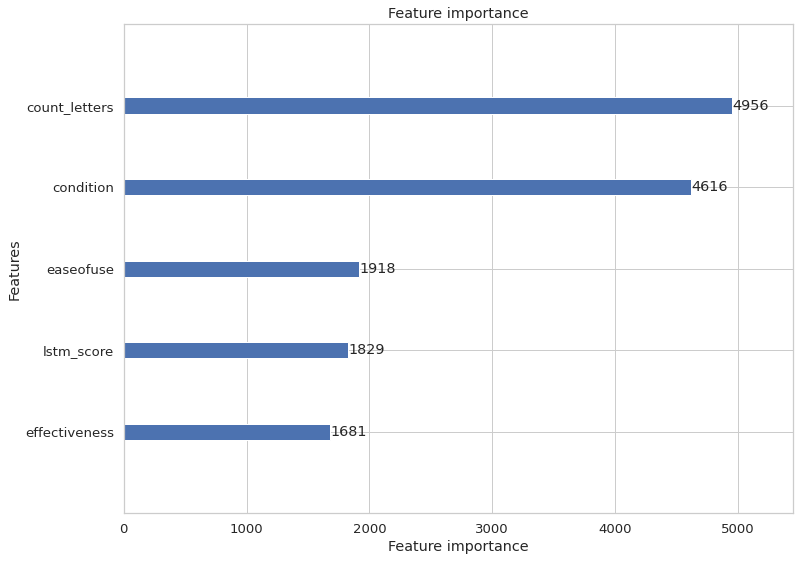

In [449]:
# Feature Importance Plot using LGBM
plt.rcParams['figure.figsize'] = [12, 9]
sns.set(style = 'whitegrid', font_scale = 1.2)
plot_importance(LGBM);

In [450]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
training_start = time.perf_counter()
LR.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = LR.predict(X_test)
prediction_end = time.perf_counter()
acc_LR = (preds == y_test).sum().astype(float) / len(preds)*100
LR_train_time = training_end-training_start
LR_prediction_time = prediction_end-prediction_start
precision_score_LR=precision_score(y_test, preds, average='micro')

y_pred1= lb.transform(preds)
roc_auc_score_LR=roc_auc_score(y_test1, y_pred1, average="macro")
print("Roc_auc_score for test data: %3.5f " % (roc_auc_score_LR))
print("Scikit-Learn's LR Classifier's prediction accuracy is: %3.2f" % (acc_LR))
print("Time consumed for training: %4.3f seconds" % (LR_train_time))
print("Time consumed for prediction: %6.5f seconds" % (LR_prediction_time))
print("Precision on test dataset:", precision_score_LR)


Roc_auc_score for test data: 0.62756 
Scikit-Learn's LR Classifier's prediction accuracy is: 40.42
Time consumed for training: 2.320 seconds
Time consumed for prediction: 0.00302 seconds
Precision on test dataset: 0.4042085427135678


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [451]:
from sklearn.ensemble import RandomForestClassifier
import time

rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
precision_score_rfc=precision_score(y_test, preds, average='micro')

y_pred1= lb.transform(preds)
roc_auc_score_rfc=roc_auc_score(y_test1, y_pred1, average="macro")
print("Roc_auc_score for test data: %3.5f " % (roc_auc_score_rfc))
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))
print("Precision on test dataset:", precision_score_rfc)

Roc_auc_score for test data: 0.72872 
Scikit-Learn's Random Forest Classifier's prediction accuracy is: 56.60
Time consumed for training: 0.405 seconds
Time consumed for prediction: 0.04124 seconds
Precision on test dataset: 0.5660332914572864


In [452]:
#After running all classifier models individually, we compare them all together for best performance
results = pd.DataFrame({
    'Model': ['KNN', 'GNB', 'LGBM', 'gbk', 'LR', 'Random Forest'],
    'Roc_auc_score': [roc_auc_score_knn, roc_auc_score_gnb, roc_auc_score_lgbm, roc_auc_score_gbk, roc_auc_score_LR, roc_auc_score_rfc],
    'Accuracy': [acc_knn, acc_gnb, acc_LGBM, acc_gbk, acc_LR, acc_rfc],
    'Precision': [precision_score_knn, precision_score_gnb, precision_score_lgbm, precision_score_gbk, precision_score_LR, precision_score_rfc],
    'Runtime Training': [knn_train_time, gnb_train_time, LGBM_train_time, gbk_train_time, 
                         LR_train_time, rfc_train_time],
    'Runtime Prediction': [knn_prediction_time, gnb_prediction_time, LGBM_prediction_time, gbk_prediction_time,
                          LR_prediction_time, rfc_prediction_time]})
result_df = results.sort_values(by='Roc_auc_score', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Roc_auc_score,Accuracy,Precision,Runtime Training,Runtime Prediction
Model,,,,,
gbk,0.770393,63.253769,0.632538,14.895503,0.121666
LGBM,0.770237,63.222362,0.632224,1.609524,0.022287
GNB,0.734802,57.514133,0.575141,0.008682,0.003544
Random Forest,0.728725,56.603329,0.566033,0.405473,0.041241
LR,0.627564,40.420854,0.404209,2.319899,0.003019
KNN,0.590893,34.579146,0.345791,0.032337,0.388738


In [453]:
from sklearn.model_selection import cross_validate
gbk_cv = GradientBoostingClassifier(n_estimators=10)
scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_micro': 'recall_macro'}
scores = cross_validate(gbk_cv, X_train, y_train, cv=3, scoring = scoring)
print("Scores:", scores)
#print("Mean:", scores.mean())
#print("Standard Deviation:", scores.std())

Scores: {'fit_time': array([1.03595829, 1.03939795, 1.03713393]), 'score_time': array([0.03010798, 0.0301466 , 0.03005624]), 'test_acc': array([0.61740359, 0.6213406 , 0.62301868]), 'test_prec_macro': array([0.61359779, 0.61760227, 0.6221036 ]), 'test_rec_micro': array([0.61735331, 0.62134563, 0.62313733])}


In [454]:
importances = pd.DataFrame({
    #'Feature': dTreated.drop('Satisfaction', axis=1).columns,
    'Feature': features.columns,
    'Importance': gbk.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=True)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
condition,0.016948
count_letters,0.018094
easeofuse,0.047387
lstm_score,0.278739
effectiveness,0.638831


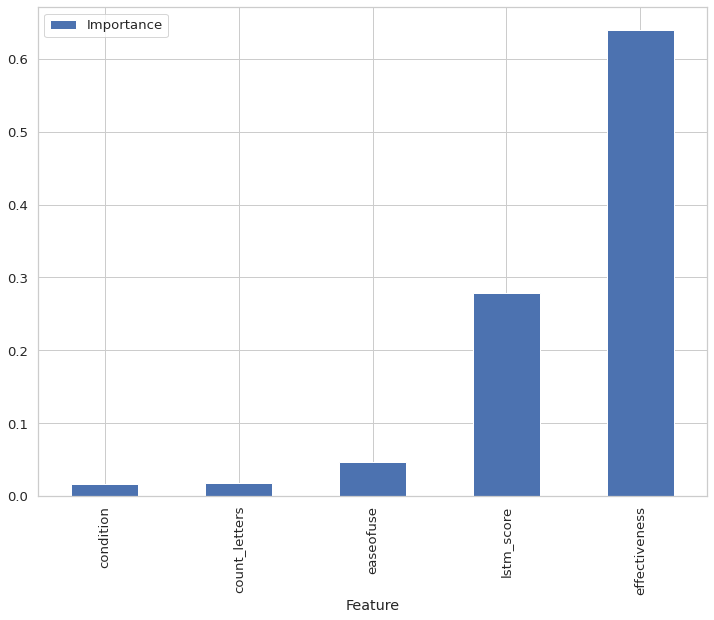

In [455]:
importances.plot.bar()

# Hyperparameter Tuning

In [456]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(gbk.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [457]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in GradientBoostingClassifier()
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
#max_features = ['None', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 19, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
learning_rate = [0.001, 0.01, 0.1, 0.2]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate}
pprint(random_grid)

{'learning_rate': [0.001, 0.01, 0.1, 0.2],
 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500]}


In [458]:
# Use the random grid to search for best hyperparameters

# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations, and use all available cores
gbk_random = RandomizedSearchCV(estimator = gbk, param_distributions = random_grid, n_iter = 1, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
gbk_random.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   39.6s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [459]:
# Best parameter values, with best score of accuracy using Hyperparameter tuning
gbk_random.best_params_,gbk_random.best_score_

({'learning_rate': 0.1,
  'max_depth': 7,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200},
 0.6081703873724128)

In [477]:
#implementing hyperopt tuning with set parameter values
GBoost = GradientBoostingClassifier(max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=400, learning_rate=0.07)
#max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=400, learning_rate=0.07

GBoost.fit(X_train, y_train)
preds = GBoost.predict(X_test)

accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

print("Gradient Boost's prediction accuracy WITH optimal hyperparameters is: %3.2f" % (accuracy))

Gradient Boost's prediction accuracy WITH optimal hyperparameters is: 63.40


In [478]:
scores = cross_validate(GBoost, X_train, y_train, cv=3, scoring = scoring)
print("Scores:", scores)

Scores: {'fit_time': array([40.17642808, 39.89439535, 39.58676553]), 'score_time': array([0.29381943, 0.29856038, 0.29381299]), 'test_acc': array([0.63204119, 0.62911367, 0.63483089]), 'test_prec_macro': array([0.62770038, 0.62461977, 0.63124409]), 'test_rec_micro': array([0.63193607, 0.62902654, 0.63480718])}


In [480]:
confusion_matrix(preds, y_test)

array([[1978,  461,  136,   33,   30],
       [ 425, 1388,  637,  138,   43],
       [  89,  471, 1230,  441,  106],
       [  42,  152,  399, 1465,  323],
       [  64,   97,  173,  402, 2013]])

In [481]:
from sklearn.metrics import recall_score, f1_score
print("Precision on test dataset:", precision_score(y_test, preds, average='micro'))
print("Recall on test dataset:",recall_score(y_test, preds, average='micro'))
print("F1-Score on test dataset:", f1_score(y_test, preds, average='micro'))

Precision on test dataset: 0.6339510050251256
Recall on test dataset: 0.6339510050251256
F1-Score on test dataset: 0.6339510050251256


In [482]:
# Classification report
import sklearn.metrics as metrics
print('\t\t\t\tCLASSIFICATIION METRICS \n \t\t\tfor test dataset\n')
print(metrics.classification_report(y_test, preds))

				CLASSIFICATIION METRICS 
 			for test dataset

              precision    recall  f1-score   support

         1.0       0.75      0.76      0.76      2598
         2.0       0.53      0.54      0.53      2569
         3.0       0.53      0.48      0.50      2575
         4.0       0.62      0.59      0.60      2479
         5.0       0.73      0.80      0.76      2515

    accuracy                           0.63     12736
   macro avg       0.63      0.63      0.63     12736
weighted avg       0.63      0.63      0.63     12736



In [483]:
y_pred1= lb.transform(preds)
# roc_auc_score for test data
roc_auc_score(y_test1, y_pred1, average="macro")

0.7713055224711969

In [484]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

statis=target
y = label_binarize(statis, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_pred1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

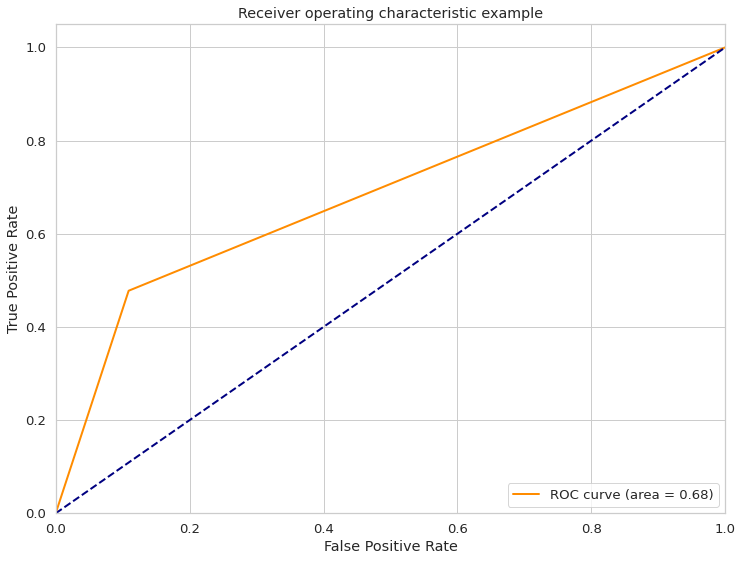

In [485]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # Remove the CWD from sys.path while we load stuff.


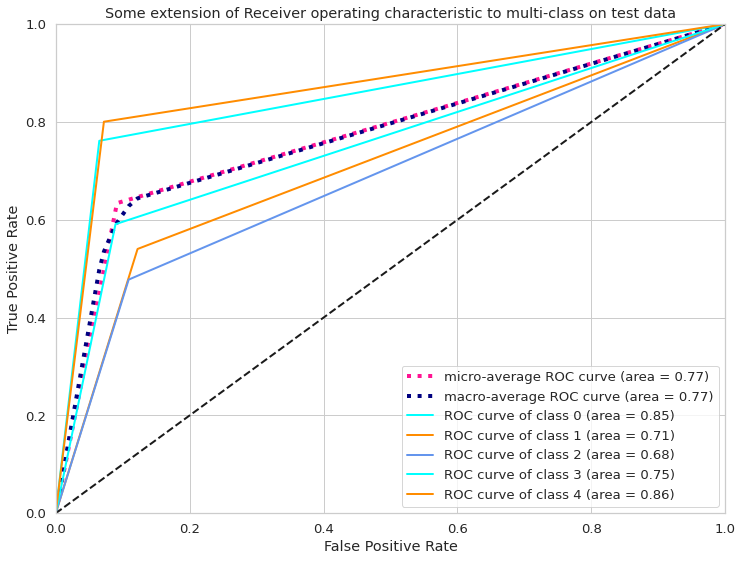

In [486]:
from scipy import interp
from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class on test data')
plt.legend(loc="lower right")
plt.show()